#**Détection de fraudes transactionnelles**


Dans ce TP, on traitera le problème de la détection d'anomalies dans le cadre dans des transactions par des cartes bancaires. 

Aujourd'hui, on se situe dans un contexte où les technologies deviennent de plus en plus accessibles au grand public. Par conséquent, des délits de fraude, liès à ces technologies, augmentent aussi et en particulier les fraudes de carte bancaire . Il est donc nécessaire de développer des solutions automatiques et adaptés aux siutations de transactions frauduleuses par carte de crédit afin que les clients ne soient pas facturés pour des articles qu'ils n'ont pas achetés.

Le but de ce TP est d'évaluer l'efficacité de l'algorithme de DBSCAN sur la tâche de détection de fraudes. Tout d'abord on procède à l'analyse et la prépation du jeu de données fourni. Le jeu de données contient des transactions effectuées par cartes de crédit en septembre 2013 par des titulaires de cartes européens. Ce jeu de données présente les transactions qui ont eu lieu en deux jours, où nous avons 492 fraudes sur 284 807 transactions. Le jeu de données est fortement déséquilibré, la classe positive (fraudes) représente 0,172% de toutes les transactions. 

Il ne contient que des caractéristiques d'entrée numériques. Pour des raisons de confidentialité, les caractéristiques V1, V2, ... V28 sont issues d'une tranformation mathématique des caractéristiques originales. Les seules caractéristiques 'Temps' et 'Montant' sont les seules à ne pas subir de transformation. La caractéristique "Temps" contient les secondes écoulées entre chaque transaction et la première transaction du jeu de données. La caractéristique 'Montant' est le montant de la transaction. La caractéristique "Classe" est la caractéristique cible et prend la valeur 1 en cas de fraude et 0 sinon.





In [3]:
#!pip install sklearn
#from yellowbrick.cluster import KElbowVisualizer
import sklearn
import datetime
import random as rand
from numpy.random import default_rng
import numpy as np
import copy
import math
import sys
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from scipy.stats import spearmanr
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.utils import parallel_backend
from sklearn.datasets import load_iris
from sklearn import metrics

In [4]:
fraudes_raw_full = pd.read_csv("jeu_de_donnees.csv")

Charger le jeu de données et afficher les 10 premières lignes. 

In [5]:
fraudes_raw_full.head(10)

,Temps,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Montant,Classe
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0.0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0.0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0.0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0.0
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0.0
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,...,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0.0
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0.0
8,7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,...,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0.0
9,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,...,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0.0


Afficher l'histogramme des nombres de cas frauduleux et cas non frauduleux.

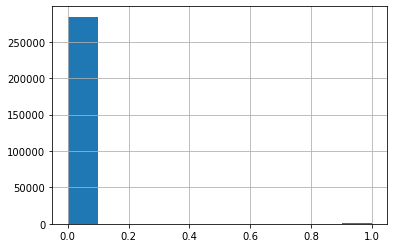

In [6]:
hist = fraudes_raw_full['Classe'].hist()

Réduire le nombre d'observations du jeu de données si la mémoire ram ne supporte le chargement du jeu de données. Afficher à nouveau l'histogramme des noms de cas frauduleux et cas non frauduleux. Assurez dans le jeu de données au moins 0,15% de cas frauduleux pour pouvoir effectuer la suite du tp.

In [7]:
def extract_sub_df(df, ratio):
    mask = []
    for i in range(len(df)):
        if rand.random() > ratio:
            mask.append(True)
        else :
            mask.append(False)
    return df[mask]

In [8]:
frauds = fraudes_raw_full[fraudes_raw_full['Classe'].astype(bool)]
clear = fraudes_raw_full[~fraudes_raw_full['Classe'].astype(bool)]

In [9]:
frauds.shape[0]

492

In [10]:
clear_reduced = extract_sub_df(clear, 0.90)
number = clear_reduced.shape[0] * 0.15/100
print("Le jeux de données doit être composé d'au moins : " + str(round(number)) +" observation frauduleuse")

Le jeux de données doit être composé d'au moins : 43 observation frauduleuse


In [11]:
mask = []
for i in range(len(frauds)):
    if rand.random() > 1-(number/len(frauds)*2) :
        mask.append(True)
    else :
        mask.append(False)

mask = np.array(mask).astype(bool)

In [12]:
frauds[mask].shape

(69, 31)

In [13]:
fraudes_raw = copy.deepcopy(clear_reduced.append(frauds[mask]))

Afficher la taille du jeu de données.

(28755, 31)


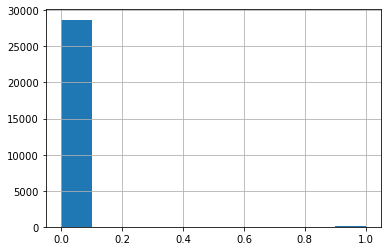

In [14]:
print(fraudes_raw.shape)
hist = fraudes_raw['Classe'].hist()

Supprimer les doublons dans le cas échéant.

In [15]:
fraudes_no_duplicates = fraudes_raw.drop_duplicates()
print(str(fraudes_raw.shape[0] - fraudes_no_duplicates.shape[0]) + " rows deleted")

18 rows deleted


In [16]:
clear = clear.drop_duplicates()

Vérifier s'il y a présence des valeurs manquantes. Le cas échéant, supprimer les lignes concernées. 




In [17]:
fraudes_no_null = fraudes_no_duplicates.dropna()
print(str(fraudes_no_duplicates.shape[0] - fraudes_no_null.shape[0]) + " rows deleted")

0 rows deleted


In [18]:
clear = clear.dropna()

In [19]:
clear.describe()

,Temps,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Montant,Classe
count,283253.000000,283253.000000,283253.000000,283253.000000,283253.000000,283253.000000,283253.000000,283253.000000,283253.000000,283253.000000,...,283253.000000,283253.000000,283253.000000,283253.000000,283253.000000,283253.000000,283253.000000,283253.000000,283253.000000,283253.0
mean,94835.058093,0.013439,-0.009829,0.012853,-0.010440,0.006769,0.001251,0.010447,-0.002448,0.002613,...,-0.001150,-0.000160,0.000360,0.000393,-0.000301,0.000065,0.001409,0.000418,88.413575,0.0
std,47475.550607,1.922179,1.633520,1.457593,1.398575,1.355816,1.329914,1.177480,1.157140,1.086902,...,0.715629,0.723541,0.621165,0.605748,0.520612,0.482080,0.392700,0.327563,250.379023,0.0
min,0.000000,-56.407510,-72.715728,-48.325589,-5.683171,-113.743307,-26.160506,-31.764946,-73.216718,-6.290730,...,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-22.565679,-15.430084,0.000000,0.0
25%,54233.000000,-0.913431,-0.601398,-0.883966,-0.851605,-0.687888,-0.767543,-0.550146,-0.208841,-0.641649,...,-0.228406,-0.542737,-0.161490,-0.354306,-0.317476,-0.326853,-0.070650,-0.052808,5.670000,0.0
50%,84711.000000,0.022562,0.062561,0.182247,-0.024500,-0.052807,-0.274172,0.041664,0.021633,-0.051368,...,-0.029798,0.006675,-0.011077,0.041115,0.016190,-0.052293,0.001368,0.011238,22.000000,0.0
75%,139308.000000,1.316788,0.797012,1.028261,0.734231,0.612442,0.397678,0.571029,0.324473,0.596969,...,0.185470,0.528136,0.147633,0.440051,0.350490,0.240023,0.090760,0.077961,77.460000,0.0
max,172792.000000,2.454930,18.902453,9.382558,16.875344,34.801666,73.301626,120.589494,18.709255,15.594995,...,22.614889,10.503090,22.528412,4.584549,7.519589,3.517346,31.612198,33.847808,25691.160000,0.0


Procéder à une analyse statistique descriptive de chaque caractéristique (moyenne, variance et autres valeurs statistiques....)

In [20]:
fraudes_no_null.describe()

,Temps,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Montant,Classe
count,28737.000000,28737.000000,28737.000000,28737.000000,28737.000000,28737.000000,28737.000000,28737.000000,28737.000000,28737.000000,...,28737.000000,28737.000000,28737.000000,28737.000000,28737.000000,28737.000000,28737.000000,28737.000000,28737.000000,28737.000000
mean,94844.353934,-0.012559,-0.005879,0.000802,0.001165,0.008790,0.009921,0.003645,0.010637,-0.008663,...,-0.010198,-0.003289,-0.005878,-0.000625,0.001749,0.000845,0.003039,0.001402,89.081559,0.002401
std,47432.235450,1.982766,1.682110,1.529284,1.429622,1.375380,1.328111,1.206559,1.135135,1.102993,...,0.677716,0.718468,0.634835,0.607252,0.524356,0.481595,0.395704,0.350840,242.669358,0.048943
min,12.000000,-37.558067,-44.639245,-30.177317,-5.600607,-35.182120,-21.248752,-31.197329,-39.267378,-9.462573,...,-18.603088,-7.417140,-27.215436,-2.759942,-5.785255,-1.726928,-8.839766,-8.364853,0.000000,0.000000
25%,54240.000000,-0.932623,-0.600538,-0.893273,-0.860611,-0.687410,-0.766649,-0.551935,-0.205443,-0.646656,...,-0.228988,-0.545198,-0.164260,-0.357540,-0.313012,-0.325496,-0.070450,-0.053242,5.900000,0.000000
50%,84599.000000,-0.002930,0.072932,0.181191,-0.022783,-0.046450,-0.264604,0.046538,0.028943,-0.052999,...,-0.031261,0.004314,-0.012744,0.040610,0.019181,-0.051452,0.002107,0.011169,21.240000,0.000000
75%,139248.000000,1.310308,0.815910,1.034942,0.744601,0.624076,0.416928,0.575698,0.334700,0.590956,...,0.183344,0.518910,0.143435,0.436517,0.350281,0.238309,0.092987,0.077875,77.000000,0.000000
max,172787.000000,2.418802,16.497472,4.079168,12.114672,31.457046,21.550496,36.877368,18.748872,9.099082,...,15.631453,6.790452,15.879421,4.014444,7.519589,3.067907,10.135597,22.620072,6900.470000,1.000000


Tracer des histogrammes des différentes caractéristiques V1 - V28 pour déterminer lesquelles sont importantes ou discriminantes par rapport à la classe. Deux histogrammes de couleur différente(un pour les cas fraduleux et l'autre des cas normaux) par caractéristique sont attendus dans un même graphe.

array([[<AxesSubplot:title={'center':'V1'}>,
        <AxesSubplot:title={'center':'V2'}>,
        <AxesSubplot:title={'center':'V3'}>,
        <AxesSubplot:title={'center':'V4'}>,
        <AxesSubplot:title={'center':'V5'}>],
       [<AxesSubplot:title={'center':'V6'}>,
        <AxesSubplot:title={'center':'V7'}>,
        <AxesSubplot:title={'center':'V8'}>,
        <AxesSubplot:title={'center':'V9'}>,
        <AxesSubplot:title={'center':'V10'}>],
       [<AxesSubplot:title={'center':'V11'}>,
        <AxesSubplot:title={'center':'V12'}>,
        <AxesSubplot:title={'center':'V13'}>,
        <AxesSubplot:title={'center':'V14'}>,
        <AxesSubplot:title={'center':'V15'}>],
       [<AxesSubplot:title={'center':'V16'}>,
        <AxesSubplot:title={'center':'V17'}>,
        <AxesSubplot:title={'center':'V18'}>,
        <AxesSubplot:title={'center':'V19'}>,
        <AxesSubplot:title={'center':'V20'}>],
       [<AxesSubplot:title={'center':'V21'}>,
        <AxesSubplot:title={'center':'V

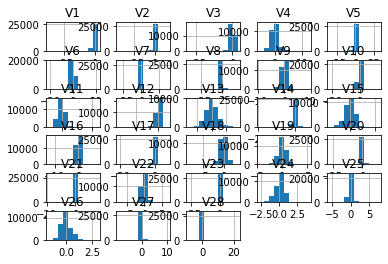

In [21]:
Vs = []
for i in range(1, 29):
    Vs.append("V{}".format(i))

    
fraudes_no_null.hist(Vs)

Calculer la corrélation entre les différentes caractéristiques de l'ensemble de données. Une carte thermique des corrélations est attendue.

<AxesSubplot:>

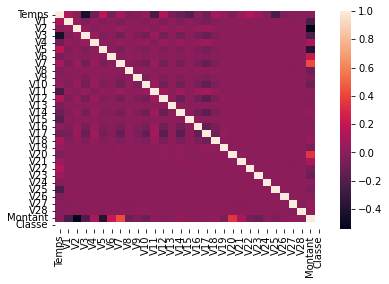

In [22]:
clear_corr = clear.corr()
sns.heatmap(clear_corr, xticklabels=clear_corr.columns, yticklabels=clear_corr.columns)

<AxesSubplot:>

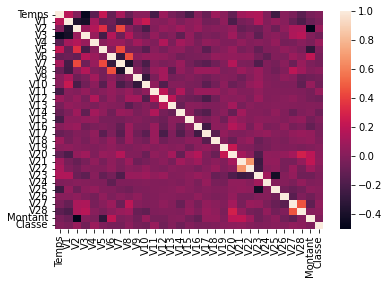

In [23]:
fraudes_corr = fraudes_no_null.corr(method="spearman")
sns.heatmap(fraudes_corr, xticklabels=fraudes_corr.columns, yticklabels=fraudes_corr.columns)

Trier les différentes colonnes de l'ensemble de données sur la base de leurs valeurs de corrélation par rapport à la classe afin d'éliminer les caractéristiques moins importantes.

In [24]:
def getColumnsToDrop(corr_df = [], number = 2):
    corr = copy.deepcopy(corr_df)
    corr = np.array(fraudes_corr['Classe']).copy()
    corr.sort()
    #corr = np.flip(corr)
    result = []
    for i in range(number):
        result.append(corr[i])
    return result

In [25]:
def rmCharac(df, labels):
    labels = [label.lower() for label in labels]
    dfLabels = df.columns.values
    for label in labels:
        if label.lower() in dfLabels:
            df = df.drop(label, 1)
        else:
            print("rmCharac - Unknown column \"" + label + "\"")
    return df

In [26]:
fraudes_corr_np = np.array(fraudes_corr['Classe']).copy()
fraudes_corr_np


array([-0.01153333, -0.03666593,  0.06190274, -0.06578124,  0.07496804,
       -0.01695742, -0.04443895, -0.05189271,  0.02223375, -0.04834574,
       -0.06699265,  0.06228672, -0.06929351, -0.00896584, -0.07837257,
       -0.00537892, -0.04364246, -0.03506394, -0.01781057,  0.01027813,
        0.02056234,  0.03390927,  0.00235674, -0.01511828, -0.00897072,
        0.01038226,  0.00168787,  0.0389865 ,  0.02451686, -0.02071729,
        1.        ])

Lister les noms des colonnes à supprimer. Choisissez par exemple les 13 colonnes les moins corrélées à la classe.


In [27]:
values = getColumnsToDrop(fraudes_corr_np, 13)
values

[-0.07837256654223441,
 -0.06929350783158535,
 -0.0669926522482477,
 -0.06578124256991302,
 -0.051892714304285034,
 -0.04834573693565604,
 -0.04443895357936262,
 -0.04364246071529271,
 -0.03666592717934492,
 -0.03506394201606818,
 -0.020717288510760743,
 -0.017810567807201125,
 -0.016957421356221688]

In [28]:
print(fraudes_corr_np)

indexes = [] 
for data in values:
    indexes.append(np.where(fraudes_corr_np == data)[0][0])

indexes = np.array(indexes)

mask = []
for i in range(fraudes_corr_np.shape[0]):
    if i in indexes:
        mask.append(False)
    else :
        mask.append(True)

mask = np.array(mask).astype(bool)
mask

[-0.01153333 -0.03666593  0.06190274 -0.06578124  0.07496804 -0.01695742
 -0.04443895 -0.05189271  0.02223375 -0.04834574 -0.06699265  0.06228672
 -0.06929351 -0.00896584 -0.07837257 -0.00537892 -0.04364246 -0.03506394
 -0.01781057  0.01027813  0.02056234  0.03390927  0.00235674 -0.01511828
 -0.00897072  0.01038226  0.00168787  0.0389865   0.02451686 -0.02071729
  1.        ]


array([ True, False,  True, False,  True, False, False, False,  True,
       False, False,  True, False,  True, False,  True, False, False,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True])

In [29]:
fraudes_corr_free = fraudes_no_null.loc[:, mask]
fraudes_corr_free.columns

Index(['Temps', 'V2', 'V4', 'V8', 'V11', 'V13', 'V15', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Classe'],
      dtype='object')

Appliquer l'algorithme de [DBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html) avec minPts=4 et eps=1 sur le jeu de données. Note: la colonne "Class" est à enlever car la tâche confiée à DBSCAN est menée en mode non supervisée.

In [30]:
def clustering_info(X, clustering):
    size = X.shape[0]

    labels = clustering.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    print("Clusters : " + str(n_clusters_))
    print("Noice : " + str(n_noise_))
    print("Noice Ratio : " + str(round(n_noise_/size, 2)))

In [31]:
def extract_sub_df(df, ratio):
    mask = []
    for i in range(len(df)):
        if rand.random() > ratio:
            mask.append(True)
        else :
            mask.append(False)
    return df[mask]

In [32]:
def dbscan(X, epsilon, samples):
    X_std = StandardScaler().fit_transform(X)
    model = DBSCAN(eps=epsilon, min_samples=samples).fit(X_std)
    d = {'Cluster': model.fit_predict(X_std)}
    return pd.DataFrame(data=d)

In [33]:
fraudes_dbscan_ready = fraudes_corr_free.drop(['Classe'], axis=1)

In [46]:
X_std = StandardScaler().fit_transform(fraudes_dbscan_ready)
model = DBSCAN(eps=1, min_samples=4).fit(X_std)
d = {'Cluster': model.fit_predict(X_std)}
data = pd.DataFrame(data=d)

Identifier à partir des résultats fournis par DBSCAN, les observations qui ont été considérés comme du bruit. Nous considérons que ces observations correspondent à des transactions frauduleuses.

In [47]:
data['Cluster'].value_counts()

-1      18165
 8       1197
 1        943
 0        755
 3        679
        ...  
 278        3
 148        3
 157        3
 99         3
 115        2
Name: Cluster, Length: 325, dtype: int64

Calculer l'intersection de l'ensemble des transactions fraduleuses du jeu de données original (qu'on appelera T) et l'ensemble des transactions fraduleurses détectés par DBSCAN, qu'on appelera D. Diviser la cardinalité de cette intersection par la cardinalité de T. On appelera ce ratio r_score. Plus ce ratio tend vers 1 plus DBSCAN est efficace dans la détection des transactions frauduleuses.

In [85]:
def score(ref, pred):
    # Copy
    fraudes_pred = copy.deepcopy(fraudes_dbscan_ready)
    fraudes_pred['Classe'] = pred['Cluster'].values
    # Clusters != -1 => OK
    fraudes_pred.loc[fraudes_pred['Classe'] > 0, 'Classe'] = 0
    fraudes_pred['Classe'] = fraudes_pred['Classe'].abs()
    # Extract frauds
    frauds_ref = ref[ref['Classe'].astype(bool)]
    frauds_pred = fraudes_pred[fraudes_pred['Classe'].astype(bool)]
    # MERGE
    df = pd.merge(frauds_ref, frauds_pred, how='left', indicator='Exist')
    
    df['Exist'] = np.where(df.Exist == 'both', True, False)
    D = df['Exist'].value_counts()[True]

    T = ref['Classe'].value_counts()[1]
    T_over = frauds_pred['Classe'].value_counts()[1] - D
    score = round((D/T)*100,2)
    print("  - r_score = " + str(score) + "%")
    print("  - Overshoot : " + str(T_over) + " observation(s)")
    return score, T_over


In [81]:
score(fraudes_corr_free, data)

  - r_score = 98.55%
  - Overshoot : 18097 observation


Relancer DBSCAN avec des valeurs de MinPts et eps au choix. Le ratio r_score a été améliorée par rapport à l'exécution précédente?

In [73]:
result = dbscan(fraudes_dbscan_ready, 8, 6)

In [74]:
score(fraudes_corr_free, result)

r_score = 10.14%
Overshoot : 76 observation


Dans la suite nous chercherons à identifier les valeurs optimales de minPts et eps. Dans cette recherche nous considérons que les kième plus proches voisins sont à peu près à la même distance. Les points bruits ont leur kième plus proche voisin à une distance plus grande. 

On fixe tout d'abord la valeur de k au choix (par exemple k=4) et on identifie selon l'approche ci-dessous la valeur de eps:
- Calculer la distance entre chaque point et son kième voisin;
- Trier les indices des points selon les distances calculées;
- Tracez la courbe des distances en fonction des points triés;
- Appliquer la méthode elbow sur cette courbre, autrement dit trouvez la distance d où il y a un "coude" dans la courbe. On considère alors eps = d et minPts = k.

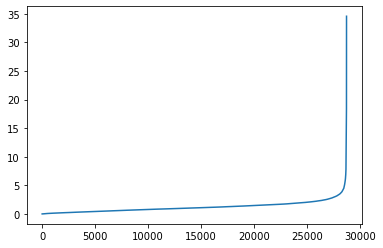

In [40]:
neigh = NearestNeighbors(n_neighbors=5)
X_std = StandardScaler().fit_transform(fraudes_dbscan_ready)
nbrs = neigh.fit(X_std)
distances, indices = nbrs.kneighbors(X_std)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

Réexécuter DBSCAN avec les nouvelles valeurs de eps et minPts. L'efficacité de DBSCAN a été améliorée?  

In [75]:
result = dbscan(fraudes_dbscan_ready, epsilon=6, samples=4)

In [82]:
score(fraudes_corr_free, result)

  - r_score = 14.49%
  - Overshoot : 138 observation


In [115]:
result = []
for sample in range(4, 8):
    for eps in range(1, 6):
        print("Pair epsilon=" + str(eps) + ", min_samples=" + str(sample)+ " : ")
        score_n, T_over_n = score(fraudes_corr_free, dbscan(fraudes_corr_free, epsilon=eps, samples=sample))
        result.append([eps, sample, score_n, T_over_n])

Pair epsilon=1, min_samples=4 : 
  - r_score = 100.0%
  - Overshoot : 18097 observation(s)
Pair epsilon=2, min_samples=4 : 
  - r_score = 94.2%
  - Overshoot : 4593 observation(s)
Pair epsilon=3, min_samples=4 : 
  - r_score = 94.2%
  - Overshoot : 1288 observation(s)
Pair epsilon=4, min_samples=4 : 
  - r_score = 46.38%
  - Overshoot : 445 observation(s)
Pair epsilon=5, min_samples=4 : 
  - r_score = 28.99%
  - Overshoot : 212 observation(s)
Pair epsilon=1, min_samples=5 : 
  - r_score = 100.0%
  - Overshoot : 18909 observation(s)
Pair epsilon=2, min_samples=5 : 
  - r_score = 100.0%
  - Overshoot : 4794 observation(s)
Pair epsilon=3, min_samples=5 : 
  - r_score = 100.0%
  - Overshoot : 1355 observation(s)
Pair epsilon=4, min_samples=5 : 
  - r_score = 52.17%
  - Overshoot : 469 observation(s)
Pair epsilon=5, min_samples=5 : 
  - r_score = 34.78%
  - Overshoot : 224 observation(s)
Pair epsilon=1, min_samples=6 : 
  - r_score = 100.0%
  - Overshoot : 19629 observation(s)
Pair epsilon=

In [92]:
result = np.array(result)

C:\Users\loict\AppData\Local\Temp/ipykernel_22144/4131967285.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['4', '5', '6'])


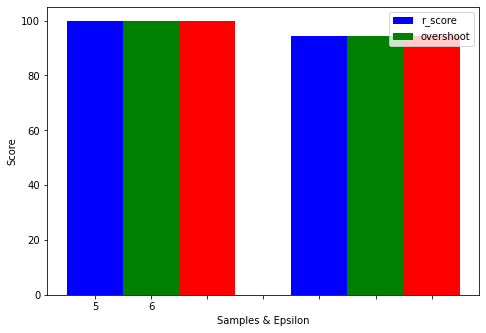

In [112]:
N = 2

ind = np.arange(N) # the x locations for the groups
width = 0.35
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

#ax.bar(ind, result[:,2], width, color='r')
#ax.bar(ind, result[:,3], width,bottom=result[:,2], color='b')

X = np.arange(3-1)
ax.bar(X + 0.00, result[:,2], color = 'b', width = 0.25)
#ax.bar(ind, result[:,3], width,bottom=result[:,2], color='b')

ax.bar(X + 0.25, result[:,2], color = 'g', width = 0.25)
ax.bar(X + 0.50, result[:,2], color = 'r', width = 0.25)

ax.set_xticklabels(['4', '5', '6'])

ax.set_xlabel('Samples & Epsilon')
ax.set_ylabel('Score')
ax.set_title('')

ax.legend(labels=['r_score', 'overshoot'])

plt.show()

Déterminer minPts et eps(selon l'approche elbow présentée ci-dessus) qui aboutit au meilleur score r_score que DBSCAN pourrait atteindre. Note: vous pourriez lister une série de valeurs possibles de minPts puis déterminer la valeur de l'eps associée selon elbow, et pour paire de valeurs de minPts et eps lancer DBSCAN.  

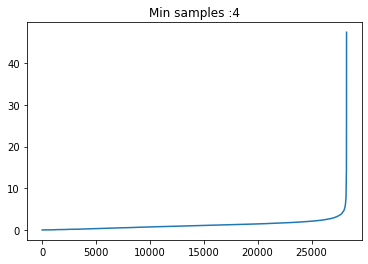

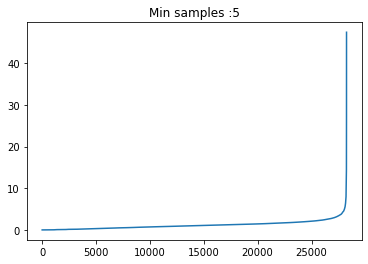

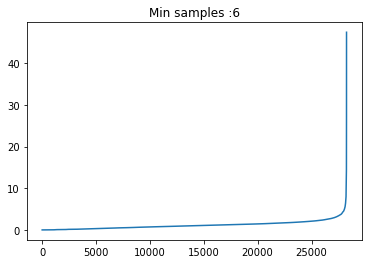

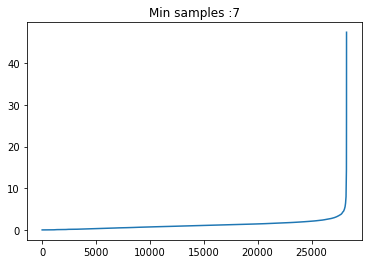

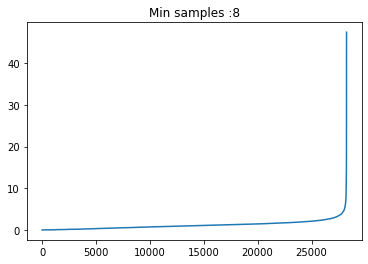

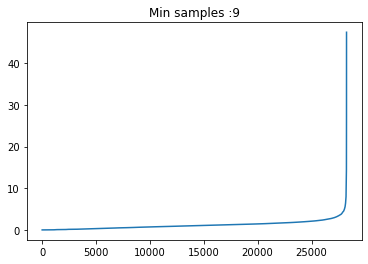

In [ ]:
for n in range(4, 10):   
    neigh = NearestNeighbors(n_neighbors=n)
    X_std = StandardScaler().fit_transform(fraudes_dbscan_ready)
    nbrs = neigh.fit(X_std)
    distances, indices = nbrs.kneighbors(X_std)
    distances = np.sort(distances, axis=0)
    distances = distances[:,1]
    plt.title("Min samples :" + str(n))
    plt.plot(distances)
    plt.show()

Dans l'optique d'améliorer la valeur r_score, nous cherchons à modifier notre jeu de données. On explorera deux possibilités:
- Supprimer davantage de colonnes les moins corrélées à la classe;
- Remettre certaines colonnes, parmi les colonnées précedement supprimées, dans le jeu de données.

Deux jeux de données seront constituées.

Pour chacun des jeux de données, appliquer l'approche précédente pour identifier une liste de valeurs optimales de minPts et eps.

Exécuter DBSCAN sur chaque paire de valeurs optimales de minPts et eps. Qu'en est-il du score r_score?